In [1]:
note="AaroBEC_minus"

In [2]:
# This one uses processed Ws inputs, so one does not have to input the array sizes manually
import qpms
from qpms.symmetries import  point_group_info
import numpy as np
from matplotlib import rcParams


rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['font.size'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
from matplotlib import pyplot as plt
import scipy
from scipy import interpolate
from scipy.constants import e as eV, hbar, hbar as ℏ, c
ň = np.newaxis
import cmath
chunksize=10
force_lMax = 3

irrep_labels = {"B2''":"$B_2''$",
                "B2'":"$B_2'$",
                "A1''":"$A_1''$",
                "A1'":"$A_1'$",
                "A2''":"$A_2''$",
                "B1''":"$B_1''$",
                "A2'":"$A_2'$", 
                "B1'":"$B_1'$"}

In [3]:
evfactor =  (eV/hbar) /( 3e8 / 1e-6 )
evfactor * 1.38, evfactor * 1.5

(6.988630318682703, 7.596337302915982)

In [4]:
#Wfile = '/m/phys/project/qd/Marek/SaraRect/SmallRectRough/380x375/all'
Wfile = '/m/phys/project/qd/Marek/AaroBEC/k0_fine/all3'

In [5]:
#freqlims = (1.436*eV/hbar,1.443*eV/hbar)
#freqlims = (1.439*eV/hbar,1.443*eV/hbar)
freqlims=None

In [6]:
#wdata = wdata_long
wdata_head = qpms.loadWfile_info(Wfile, lMax=force_lMax, midk_halfwidth=None,freqlimits=freqlims)
lMax = wdata_head['lMax']
nelem = wdata_head['nelem']
nfreqs_total = wdata_head['nfreqs']

In [7]:
#wdata.keys(), wdata['nk'], wdata['ks'], wdata['Ws'].shape
wdata_head['npart'], wdata_head['lMax']

(1, 3)

In [8]:
#### T-matrices from file
# Original Ag:
TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/AaroBEC/cylinder_50nm_lMax4_cleaned.TMatrix'
freqscale=1
# Zero loss "Ag":
#TMatrix_file = '/u/46/necadam1/unix/tmatrix-experiments/Cylinder/hexlasingPaper/zeroloss/cylinder_50nm_lMax2_long.TMatrix'

TMatrices_orig, freqs_orig, freqs_weirdunits_orig, lMaxTM = qpms.loadScuffTMatrices(TMatrix_file, normalisation = 2, version = 'new', freqscale=freqscale)
tmtype="Scuff"

In [9]:
# TODO synchronize the TM/W lMaxes better
TMatrices_orig = TMatrices_orig[...,:,0:nelem,:,0:nelem]
#lMaxTM = lMax

(1788, 1, 1, 2, 15, 1, 2, 15)
[[0. 0.]] 1
0.0


/u/46/necadam1/unix/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:170: RuntimeWarning: invalid value encountered in true_divide


B2' 0.19732697880919503 1.0
B1'' 0.19732697880919503 1.0
A1' 1.4275344024180885 7.23436
A2' 1.4275265093389362 7.23432
B1' 0.19732697880919503 1.0
A1'' 0.19732697880919503 1.0
A2'' 0.19732697880919503 1.0
B2'' 1.4275265093389362 7.23432
(1788, 1, 1, 2, 15, 1, 2, 15)
[[0. 0.]] 1
0.0
B2' 0.19732697880919503 1.0
B1'' 0.19732697880919503 1.0
A1' 1.4275344024180885 7.23436
A2' 0.19732697880919503 1.0
B1' 1.4275422954972408 7.2344
A1'' 0.19732697880919503 1.0
A2'' 0.23679237457103405 1.2
B2'' 0.19732697880919503 1.0
(1788, 1, 1, 2, 15, 1, 2, 15)
[[0. 0.]] 1
0.0
B2' 0.2762577703328731 1.4
B1'' 1.4276626649543145 7.23501
A1' 1.4275344024180885 7.23436
A2' 0.19732697880919503 1.0
B1' 0.31572316609471207 1.6
A1'' 0.2762577703328731 1.4
A2'' 1.4601604450944008 7.3997
B2'' 0.19732697880919503 1.0


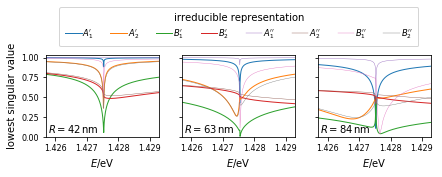

In [47]:
%matplotlib inline
layout='horizontal'
#f, ax = plt.subplots(2,1, sharex=True, sharey=False, figsize=(40/25.4, 46/25.4))
if layout == 'vertical':
    f, ax = plt.subplots(3,1, sharex=True, sharey=False, figsize=(80/25.4, 100/25.4))
else:
    f, ax = plt.subplots(1,3, sharex=False, sharey=True, figsize=(160/25.4, 60/25.4))
irreps_to_plot = ["A1'",
                 "A2'",
                 "B1'",
                 "B2'",
                 "A1''",
                 "A2''",
                 "B1''",
                 "B2''",
                 ]
for axi, radfactor in enumerate((1,1.5,2.0)):
    #### Alternatively, Mie T-matrix
    lMaxTM = force_lMax
    lMax = lMaxTM

    nelem = lMax * (lMax + 2)
    startω =1*eV/ℏ
    stopω = 2*eV/ℏ
    ωlist = np.linspace(startω, stopω, 200)


    ε_b = 1.52**2
    R = 42e-9*radfactor

    if False: # drude model
        ω_p = 9*eV/ℏ #9*eV/ℏ
        ε_inf = 4.6
        γ_p = 0#0.07*eV/ℏ

        ε_mlist = qpms.ε_drude(ε_inf, ω_p, γ_p, ωlist)
        tmtype="MieDrude%gnm" % (R/1e-9)
    else: # interpolated data
        permdata = np.loadtxt("/u/46/necadam1/unix/tmatrix-experiments/materialy/Ni-Johnson-simple.dat")
        permfreqs = permdata[:,0]
        permvals = permdata[:,1] + permdata[:,2]*1j
        permdata_interp = interpolate.interp1d(permfreqs, permvals, axis = 0, kind='linear', fill_value='extrapolate')
        ε_mlist = permdata_interp(ωlist)
        tmtype="MieInterp%gnm" % (R/1e-9)


    RVlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)
    RHlist = np.empty((lMax+1,)+ωlist.shape,dtype=np.complex_)

    for i in range(len(ωlist)):
        ω=ωlist[i]
        k_i = cmath.sqrt(ε_mlist[i])*ω/c
        k_e = cmath.sqrt(ε_b)*ω/c
        RH, RV, TH, TV = qpms.mie_coefficients(a=R, nmax=lMax, k_i=k_i, k_e=k_e, J_ext=1, J_scat=3)
        RVlist[:,i] = RV
        RHlist[:,i] = RH

    y = np.arange(nelem)
    my, ny = qpms.get_mn_y(lMax)

    TMatrices_orig = np.zeros((RVlist.shape[1], 2, nelem, 2, nelem), dtype=complex)

    for l in range(1,lMax+1):
        beg = l**2-1
        end = l*(l+2)
        TMatrices_orig[:,0,beg:end,0,beg:end] = -RVlist[l,:,ň,ň] * np.eye(2*l+1) # FIXME opposite sign?
        TMatrices_orig[:,1,beg:end,1,beg:end] = -RHlist[l,:,ň,ň] * np.eye(2*l+1)

    freqs_orig = ωlist

    lMax = lMaxTM  # redundant
    nelem = qpms.get_nelem(lMax) #redundant
    nomega = wdata_head['nfreqs'] # 286
    nk = wdata_head['nk'] #100
    npart = wdata_head['npart']
    wdata_head['freqs'][0]/(eV/hbar), wdata_head['freqs'][-1] / (eV/hbar)

    #nomega, nk, wdata['freqs'][151]/(eV/hbar), wdata['freqs'][-125] / (eV/hbar), wdata['ks'][12][1], wdata['ks'][-33][1]
    #nomega, nk, wdata_head['freqs'][0]/(eV/hbar), wdata_head['freqs'][-1] / (eV/hbar), wdata_head['ks'][22][1]*4.085/4.199, wdata_head['ks'][-19][1]*4.085/4.199

    if False:
        #symmetrize TMatrices
        yfl = qpms.yflip_tyty(lMax)
        xfl = qpms.xflip_tyty(lMax)
        zfl = qpms.zflip_tyty(lMax)
        TMatrix=TMatrices_orig
        TMatrix_sym = (TMatrix + qpms.apply_ndmatrix_left(yfl,qpms.apply_ndmatrix_left(yfl, TMatrix, (-4,-3)),(-2,-1)))/2
        TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(xfl,qpms.apply_ndmatrix_left(xfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
        TMatrix_sym = (TMatrix_sym + qpms.apply_ndmatrix_left(zfl,qpms.apply_ndmatrix_left(zfl, TMatrix_sym, (-4,-3)),(-2,-1)))/2
        rotN = 600

        TMatrix_contribs = np.empty((rotN,)+TMatrix.shape, dtype=np.complex_)
        for i in range(rotN):
            rotangle = 2*np.pi*i / rotN
            rot =  qpms.WignerD_yy_fromvector(lMax,np.array([0,0,rotangle]))
            rotinv = qpms.WignerD_yy_fromvector(lMax,np.array([0,0,-rotangle]))
            TMatrix_contribs[i] = qpms.apply_matrix_left(rot,qpms.apply_matrix_left(rotinv, TMatrix_sym, -3),-1)
        TMatrix_sym = np.sum(TMatrix_contribs, axis=0) / rotN
        TMatrix_sym[np.abs(TMatrix_sym) <= 1e-16] = 0
    else:
        TMatrix_sym = TMatrices_orig

    # TODO process (interpolate and symmetrize) T-matrix here
    TMatrices_interp = interpolate.interp1d(freqs_orig, TMatrix_sym, axis = 0, kind='linear', fill_value='extrapolate')


    #Wmatrices = wdata['Ws'].reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
    #Wmatrices = (wdata_long['Ws']+0*wdata_short['Ws']).reshape((nomega,nk,npart,2,nelem,npart,2,nelem))
    #TMatrices = TMatrix_sym.reshape((nomega,1,2,nelem,2,nelem))
    ks = np.broadcast_to(wdata_head['ks'][ň,:,:], (nomega, nk, 2))
    freqs = np.broadcast_to(wdata_head['freqs'][:,ň], (nomega,nk))

    #Wmatrices.shape, 
    ks.shape, freqs.shape


    TMatrices_orig.shape, ks.shape, freqs.shape

    #lMax = 2
    nelem = lMax * (lMax+2)
    wdata_thin = qpms.loadWfile_processed(Wfile, lMax=lMax, midk_halfwidth=0, midk_index=0,freqlimits=None)
    npart=wdata_thin['npart']
    Wmatrices = wdata_thin['Ws'][::4]
    print(Wmatrices.shape)
    nk = wdata_thin['nk']
    freqs = wdata_thin['freqs'][::4]
    nfreqs = len(freqs)
    nomega = nfreqs
    ks = wdata_thin['ks']
    print(ks, nk)
    #lMax = wdata_head['lMax']
    #nelem = wdata_head['nelem']

    lineindex = nk//2+0
    linek = ks[lineindex,1]
    linefreqs = freqs
    linefreqs_weirdunits = wdata_thin['freqs_weirdunits'][::4]
    lineWmatrices = Wmatrices[:,lineindex]
    print(linek)


    thegroup = 'D2h' # zde se vybírá příslušná grupa
    #thegroup = 'y_and_z_flip_group' # The x and y axis definitions are still somehow swapped / wrong
    #thegroup = 'D4h'

    projmats = point_group_info[thegroup].svwf_irrep_projectors(lMax)
    for rep, W in projmats.items(): # reshape to ptypty, the rest of the code expects it, although we have only one particle per unit cell
        projmats[rep] = W.reshape((1,2,nelem,1,2,nelem))

    projmats2, bases = point_group_info[thegroup].svwf_irrep_projectors2_w_bases(lMax)
    for rep, W in projmats2.items(): # reshape to ptypty, the rest of the code expects it, although we have only one particle per unit cell
        projmats2[rep] = W.reshape((1,2,nelem,1,2,nelem))
    for rep, b in bases.items():
        bases[rep] = b.reshape((b.shape[0],1,2,nelem))
    #bases["A1'"].shape


    WMatrices_projs = dict()
    for rep, P in projmats.items():

        WP = np.tensordot(lineWmatrices, P, axes=([-3,-2,-1],[0,1,2]))
        PWP = np.tensordot(P,WP, axes=([-3,-2,-1],[1,2,3]))
        PWP = np.rollaxis(PWP, 3)
        WMatrices_projs[rep] = PWP

    WMatrices_reconstructed = np.zeros(lineWmatrices.shape, dtype=complex)
    for PWP in WMatrices_projs.values():
        WMatrices_reconstructed += PWP

    (np.amax(np.nan_to_num(np.abs(WMatrices_reconstructed-lineWmatrices)/(np.abs(WMatrices_reconstructed)+np.abs(lineWmatrices)))),
     np.amax(np.abs(WMatrices_reconstructed-lineWmatrices)))

    finalMatrices = np.empty((nomega, npart,2,nelem, npart,2,nelem), dtype=complex)
    # Full problem
    for omi in range(nomega):
            W = lineWmatrices[omi]
            T = TMatrices_interp(linefreqs[omi])
            TW = np.sum(
                T[...,ň,:,:,:,:,ň,ň,ň] * W[...,:,ň,ň,:,:,:,:,:]
            , axis = (-5,-4))
            iden = np.eye(npart*2*nelem)
            iden.shape = (npart,2,nelem,npart,2,nelem)
            finalMatrix = iden+TW
            finalMatrices[omi] = finalMatrix

    lineS_irrep = dict()
    for rep, B in bases.items():
        N = B.shape[0]
        lineS_thisirrep = np.full((nomega,N), np.nan)
        #B_H = np.moveaxis(B,0, -1).conj() # (N,2,2,nelem) -> (2,2,nelem,N)
        B_H = B.conj()
        B = np.moveaxis(B,0,-1)
        for omi in range(nomega):
                M = finalMatrices[omi]
                MB = np.tensordot(M,B,axes=([-3,-2,-1],[0,1,2]))
                finalMatrix_irrep = np.tensordot(B_H, MB, axes=([-3,-2,-1],[0,1,2]))
                try:
                    #allU[omi,ki], allS[omi,ki], allV[omi,ki] = scipy.linalg.svd(finalMatrix.reshape((npart*nelem,npart*nelem)), 
                    lineS_thisirrep[omi] = scipy.linalg.svd(finalMatrix_irrep, compute_uv = False,
                                                                               # lapack_driver= 'gesvd'
                                                                               )
                except ValueError:
                    pass
        lineS_irrep[rep] = lineS_thisirrep

    s = 1
    focus = 0 # None, 0, 1

    center = 2.14505
    span = 0.0007
    dc1 = (2.17366243 - center) / (-5)
    dc2 = (2.117206400 - center) / 5

    focstrings = {None: '', 0: 'central', 1: 'side'}
    amaxes = []
   
    legend_handles = list()
    for rep in irreps_to_plot:
        lineSp = lineS_irrep[rep]
        handle, = ax[axi].plot(linefreqs/eV*hbar, lineSp[:,-s], label=irrep_labels[rep],# ls=':' if "''" in rep else '-',
                               lw= 0.4 if "''" in rep else 1,
                              )
        legend_handles.append(handle)
        amaxes.append(np.amax(lineSp[:,-s]))
    plt.ylim([0,min(2, max(amaxes))])
    if focus == 0:
        ax[axi].set_xlim([1.4257,1.4293])
        #plt.xlim([center - span/2, center + span/2])
    elif focus == 1:
        dc = dc1 if p2 < 380 else dc2
        ax[axi].set_xlim([center + (p2-380)*dc - span/2,center + (p2-380)*dc + span/2])
    ax[axi].set_ylim([0,1.03])
    if False:
      ax[axi].text(0.02,
         0.03,
        '(%c)' % (97+axi), # 'a' + i in asci
        horizontalalignment='left',
        transform=ax[axi].transAxes,
        verticalalignment='bottom',
        color='k',
        #fontsize = 'x-small'
       )
    ax[axi].text(0.02, 0.03, '$R=%.0f\,\mathrm{nm}$' % (R/1e-9, ),
        horizontalalignment='left',
        transform=ax[axi].transAxes,
        verticalalignment='bottom',
        color='k',)
    if layout != 'vertical':
        if axi == 0:
            ax[axi].set_ylabel('lowest singular value')
        ax[axi].set_xlabel('$E/\\mathrm{eV}$')

    for rep in lineS_irrep.keys():
        print(rep, linefreqs[np.argmin(lineS_irrep[rep][:,-s])]/eV*hbar, linefreqs_weirdunits[np.argmin(lineS_irrep[rep][:,-s])])
#plt.legend()
#plt.title('571 nm x 621 nm, $k_y = %g\\, \\mathrm{m^{-1}}$, irreps of group %s, %s lowest singular value of each irrep, %s T-Matrix%s' % (linek, thegroup, {1: '1st', 2:'2nd', 3:'3rd'}[s], tmtype, 
#                                                                                                                                             '' if focus is None else (', %s bundle' % focstrings[focus])))

#f.text(0.600, 0.00, '$E/\\mathrm{eV}$', ha='center', fontsize=8)
if layout == 'vertical':
    f.text(0.00, 0.53, 'lowest singular value', va='center', rotation='vertical', fontsize=8)
    ax[2].set_xlabel('$E/\\mathrm{eV}$', fontsize=8)
ax[1 #if layout=='vertical' else 2
  ].legend(legend_handles, [irrep_labels[rep] for rep in irreps_to_plot], 
           loc='center right' if layout=='vertical' else 'center', 
           title='irrep' if layout =='vertical' else 'irreducible representation',
         bbox_to_anchor= (1.32,0.5) if layout=='vertical' else (0.5,1.35),
         borderaxespad = 0,
         borderpad=0.7,
         #labelspacing=0.1,
         handletextpad=0.09,
         #columnspacing=0.2,
         ncol = 1 if layout=='vertical' else 8,
         fontsize='small')
if layout=='vertical':
    f.subplots_adjust(left=0.05, right=0.78, bottom=0.10, top=0.98,)
else:
    f.subplots_adjust(left=0.1, right=0.95, bottom=0.20, top=0.68, hspace=0.00, )
plt.savefig("figs/paperfig_inf_sphere_3radii_horizontal.pdf")


